<a href="https://colab.research.google.com/github/Sahanaka/GANs/blob/main/GAN_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GAN for MNIST**

In this notebook we will train a GAN on the MNIST dataset to see how to generate new images.

## **Imports**

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

## **Utilities**

The following function will be used to plot the generate GAN image while it's training.

In [2]:
def plot_multiple_images(images, n_cols=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)  
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

## **Download and Prepare the Dataset**

We will only use the train dataset.

In [3]:
# Load the train set of the MNIST dataset
(X_train, _), _ = keras.datasets.mnist.load_data()

# Normalize pixel values
X_train = X_train.astype(np.float32) / 255

11501568/11490434 [==============================] - 0s 0us/step


Batching and Shuffling of the data

In [4]:
BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

## **Model**
We will now create the two main parts of the GAN: 
* Generator - creates the fake data
* Discriminator - determines if an image is fake or real

We will stack Dense layers using the Sequential API to build these sub networks.

### Generator
The generator takes in random noise and uses it to create fake images. For that, this model will take in the shape of the random noise and will output an image with the same dimensions of the MNIST dataset (i.e. 28 x 28). 

[SELU](https://arxiv.org/abs/1706.02515) is found to be a good activation function for GANs and we use that in the first two dense networks. The final dense networks are activated with a sigmoid because we want to generate pixel values between 0 and 1. This is then reshaped to the dimensions of the MNIST dataset.

In [6]:
# Shape of the random noise
random_normal_dimensions = 32

generator = keras.models.Sequential([
                                     keras.layers.Dense(64, activation="selu", input_shape=[random_normal_dimensions]),
                                     keras.layers.Dense(128, activation='selu'),
                                     keras.layers.Dense(28 * 28, activation='sigmoid'),
                                     keras.layers.Reshape([28, 28])
])

The below cell runs the untrained generator. We will just see only Noise.

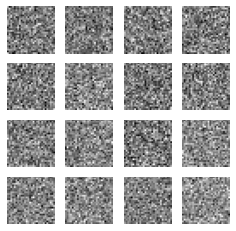

In [7]:
# generate a batch of noise input (batch size = 16)
test_noise = tf.random.normal([16, random_normal_dimensions])

# feed the batch to the untrained generator
test_image = generator(test_noise)

# visualize sample output
plot_multiple_images(test_image, n_cols=4)

### Discriminator

The discriminator takes in the input (fake or real) images and determines if it is fake or not. Thus, the input shape will be that of the training images. This will be flattened so it can be fed to the dense networks and the final output is a value between 0 (fake) and 1 (real).

Like the generator, we use SELU activation in the first two dense networks and we activate the final network with a sigmoid.

In [8]:
discriminator = keras.models.Sequential([
                                         keras.layers.Flatten(input_shape=[28, 28]),
                                         keras.layers.Dense(128, activation='selu'),
                                         keras.layers.Dense(64, activation='selu'),
                                         keras.layers.Dense(1, activation='sigmoid'),
])

Now we can stack the models in a sequential model.

In [9]:
gan = keras.models.Sequential([generator, discriminator])

## **Configure Training Parameters**

We will now prepare the models for training. We can measure the loss with `binary_crossentropy` because we're expecting labels to be either 0 (fake) or 1 (real).

In [10]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False # Only train the generator 
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

## **Train the Model**

Next, we will define the training loop. This consists of two phases:

* Phase 1 - trains the discriminator to distinguish between fake or real data
* Phase 2 - trains the generator to generate images that will trick the discriminator

At each epoch, we will display a sample gallery of images to see the fake images being created by the generator. The details of how these steps are carried out are shown in the code comments below.

**We set the number of epochs for a lower value to avoid longer training. But for higher accuracies this should be done.**

In [13]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=25):
  # Get the 2 sub layers (generator, discriminator from the GAN)
  generator, discriminator = gan.layers

  # Start the training loop
  for epoch in range(n_epochs):
    print("Epoch {}/{}".format(epoch + 1, n_epochs))
    for real_images in dataset:
      batch_size = real_images.shape[0] # Batch size

      # Train the discriminator - PHASE 1
      noise = tf.random.normal(shape=[batch_size, random_normal_dimensions]) # Create the noise

      fake_images = generator(noise) # Generating fake images using noise

      # Create a list by concatenating the fake images with the real ones
      mixed_images = tf.concat([fake_images, real_images], axis=0)

      # Create the labels for the discriminator
      # 0 for the fake images
      # 1 for the real images
      discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

      discriminator.trainable = True

      discriminator.train_on_batch(mixed_images, discriminator_labels)

      # Train the discriminator - PHASE 2
      # Create a batch of noise input to feed to the GAN
      noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

      generator_labels = tf.constant([[1.]] * batch_size) # Label all images as 'real'

      discriminator.trainable = False # Set this to False. We don't need to retrain the discriminator

      # Train the GAN on the noise with the labels all set to be true
      gan.train_on_batch(noise, generator_labels)

    # plot the fake images used to train the discriminator
    plot_multiple_images(fake_images, 8)                     
    plt.show()


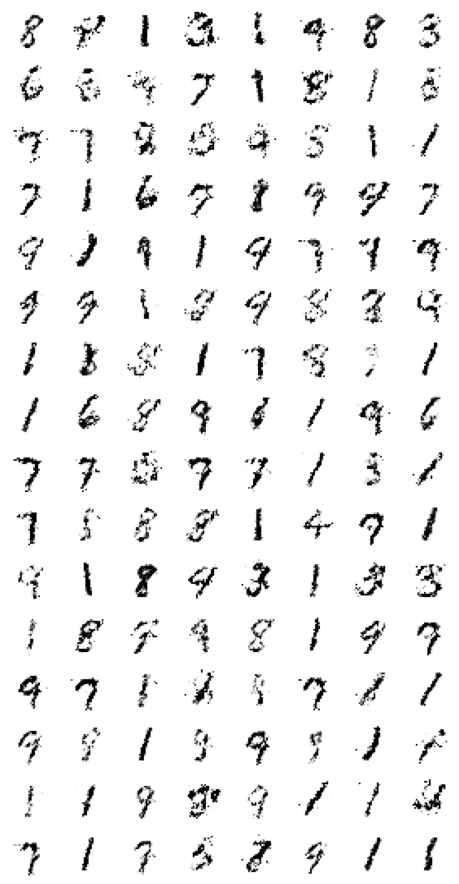

In [14]:
train_gan(gan, dataset, random_normal_dimensions, n_epochs=20)